<a href="https://colab.research.google.com/github/HungPham2002/simple-image-retrieval-system/blob/main/basic_image_retrieval_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download dataset

In [5]:
!unzip /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/image_retrieval_dataset.zip
# custom paths

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5415.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5416.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5417.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5418.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5419.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/542.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5420.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5421.jpg  
  inflating: /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval/images_mr/5422.jpg  
  inflating: /content/drive/MyDrive

In [7]:
%cd /content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval

/content/drive/MyDrive/Colab_Notebooks/AIO_Project/image_Retrieval


In [10]:
dataset_dir = './images_mr'
image_filenames = os.listdir(dataset_dir)

In [12]:
src_images = []

for filename in image_filenames:
  filepath = os.path.join(
      dataset_dir,
      filename
  )
  image = cv2.imread(filepath)
  image = cv2.cvtColor(
      image,
      cv2.COLOR_BGR2RGB)
  src_images.append(image)


In [45]:
print(src_images[0].shape)
print(type(src_images[0]))
print(len(src_images))

(85, 128, 3)
<class 'numpy.ndarray'>
9908


# Preprocess image

In [53]:
# Resize image
def image_resize(images, target_size=(64,64)):
  resized_image = cv2.resize(
      images,
      target_size
  )
  return resized_image

# Normalization

def mean_std(images):
  mean = np.mean(images, axis = (0,1,2))
  std = np.std(images, axis = (0,1,2))
  return mean, std

def image_normalization(images, mean, std):
  normalized_image = (images - mean) / std
  return normalized_image

# Flatten

def image_flatten(images, is_batch):
  # for flatten a bunch of images
  if is_batch:
    flattened_image = images.reshape(images.shape[0], -1)
  # For flatten a single image
  else:
    flattened_image = images.reshape(-1)

  return flattened_image


In [54]:
# process the whole dataset
def preprocess_batches(images):
  resized_images = [
      image_resize(image) for image in src_images
      ]
  images_arr = np.array(resized_images)
  mean, std = mean_std(images_arr)
  normalized_images = image_normalization(images_arr, mean, std)
  flattened_images = image_flatten(
      normalized_images,
      is_batch = True
  )

  return flattened_images, mean, std

# process a single image
def preprocess_query(image, mean, std):
  resized_image = image_resize(image)
  normalized_image = image_normalization(resized_image, mean, std)
  flattened_image = image_flatten(normalized_image, is_batch = False)

  return flattened_image


# Similarity Measurement (whatever)

In [22]:
def mean_absolute_error(query_vector, src_vectors):
  abs_diff = np.abs(src_vectors - query_vector)
  mae = np.neab(abs_diff, axis = 1)

  return mae

def mean_squared_error(query_vector, src_vectors):
  squared_error = (src_vectors - query_vector)**2
  mse = np.mean(squared_error, axis = 1)

  return mse


def cosine_similarity(query_vector, src_vectors):
  query_norm = np.linalg.norm(query_vector)
  normalized_query = query_vector / query_norm
  src_norms = np.linalg.norm(src_vectors, axis=1)
  normalized_src = src_vectors / src_norms[:, np.newaxis]

  cosine_similarity = np.dot(
      normalized_src,
      normalized_query
  )
  return cosine_similarity

def corrlation_coefficient(query_vector, src_vectors):
  corr_coef = np.corrcoef(
      query_vector,
      src_vectors
  )[:-1,-1]
  return corr_coef

# Ranking

In [16]:
def ranking(
    preprocessed_query_image,
    preprocessed_src_images,
    top_k = 10
):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

Query Image


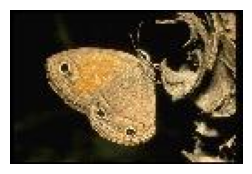

Top 10 results


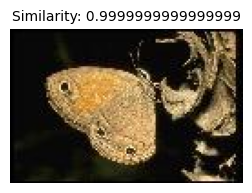

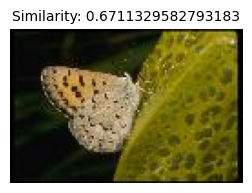

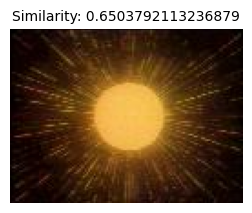

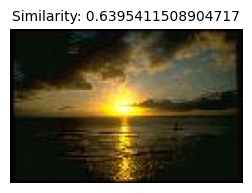

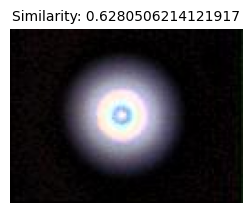

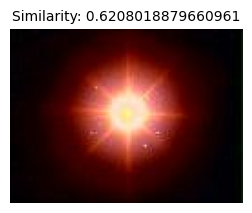

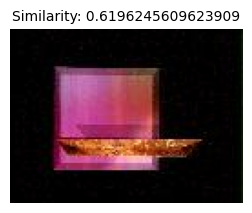

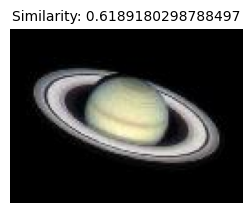

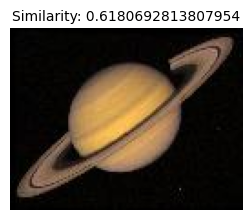

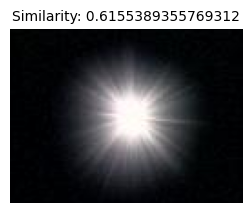

----------------------------------------


In [70]:
query_image_paths = [
    '/content/images_mr/10.jpg'
]
top_k = 10
preprocessed_src_images, mean, std = preprocess_batches(src_images)
for query_image_path in query_image_paths:
  query_image = cv2.imread(query_image_path, 1)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocess_query(query_image, mean, std)


  ranked_list, scores = ranking(
      preprocessed_query_image,
      preprocessed_src_images,
      top_k
  )
  print('Query Image')
  plt.figure(figsize=(3,3))
  plt.imshow(query_image)
  plt.axis('off')
  plt.show()

  print(f'Top {top_k} results')
  for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3,3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show()
  print('----------------------------------------')